In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score

2025-11-09 08:03:51.203259: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-09 08:03:51.262302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-09 08:03:53.964189: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
x = data.drop("Class", axis = 1)
y = data["Class"]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_train,x_test,y_train,y_test = train_test_split(x_scaled,y,test_size = 0.2, random_state=42)

In [4]:
#For training autoencoder
x_train_norm  = x_train[y_train == 0]

#Encoder
input_dim = x_train_norm.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation = 'relu')(input_layer)
encoder = Dense(7,activation = 'relu')(encoder)

decoder = Dense(encoding_dim, activation = 'relu')(encoder)
decoder = Dense(input_dim, activation = 'sigmoid')(decoder)

I0000 00:00:1762675440.060861    2451 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1765 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
autoencoder = Model(
                inputs = input_layer,
                outputs = decoder)

autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                    loss = 'mse',
                    metrics = ['mae'])

history = autoencoder.fit(x_train_norm,x_train_norm,
                          epochs = 2,
                          batch_size = 64,
                          validation_split = 0.2,
                          shuffle = True,
                          verbose = 1)

Epoch 1/2


2025-11-09 08:04:01.779057: I external/local_xla/xla/service/service.cc:163] XLA service 0x71646400b940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-09 08:04:01.779103: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-11-09 08:04:01.820875: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-09 08:04:02.056069: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301


  20/2844 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 1.2589 - mae: 0.8071

I0000 00:00:1762675446.078949    2523 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2844/2844 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.8600 - mae: 0.6109 - val_loss: 0.8184 - val_mae: 0.5798
Epoch 2/2
2844/2844 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.7888 - mae: 0.5704 - val_loss: 0.8001 - val_mae: 0.5674


In [6]:
reconstructions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - reconstructions, 2), axis = 1)

threshold = np.percentile(mse,95)
threshold

y_pred  = (mse > threshold).astype(int)
confusion_matrix(y_test,y_pred)

print("\nClassification Report: \n", classification_report(y_test,y_pred, digits = 4))

roc_auc_score(y_test,mse)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step

Classification Report: 
               precision    recall  f1-score   support

           0     0.9998    0.9514    0.9750     56864
           1     0.0309    0.8980    0.0597        98

    accuracy                         0.9514     56962
   macro avg     0.5154    0.9247    0.5174     56962
weighted avg     0.9981    0.9514    0.9735     56962



0.9623984688135242

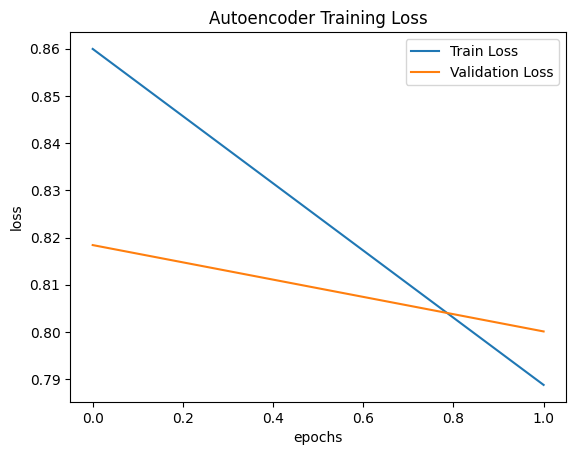

In [7]:
#plot
plt.plot(history.history['loss'], label = "Train Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.title("Autoencoder Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [9]:
 # Count
 print("\nNormal Transactions:", sum(y == 0))
 print("Fraudulent Transactions:", sum(y == 1))


Normal Transactions: 284315
Fraudulent Transactions: 492
